In [17]:
import matplotlib.pyplot as plt
import numpy as np
import glob
from astropy.io import fits

In [18]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

def load_plz(pattern):
    
    files = sorted(glob.glob(pattern))
    files = map(fits.open, files)
    files = [file[0].data for file in files]
    return np.array(files)
    
def lazy_load_plz(pattern):
    
    files = sorted(glob.glob(pattern))
    files = map(fits.open, files)
    return files

def num_sd(arr):
    
    return np.abs(arr - arr.mean()) / arr.std()
    
def apply_mask(arr, mask):
    
    arr = arr.astype(np.float32)
    
    arr *= mask
    arr[1:-1, 1:-1] += ~mask[1:-1, 1:-1] * 0.25 * \
                      (arr[:-2, 1:-1] + arr[2:, 1:-1] +
                       arr[1:-1, :-2] + arr[1:-1, 2:])
    return arr

In [178]:
N = 2
data_fitfunc = np.poly1d(np.polyfit(x,y,N)) #creates a function that takes in a point and fits it to all data

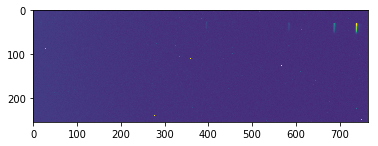

In [180]:
nebulae = sorted(glob.glob("../../../chris_kiran_jeffrey_lab2/nebula*.FIT"))
nebulae = list(map(fits.open, nebulae[:]))
nebulae = nebulae[0][0].data
plt.imshow(nebulae, norm=LogNorm(vmin=8e3, vmax=1e4));

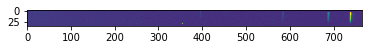

In [181]:
nebulae = nebulae[25:60, :]
plt.imshow(nebulae, norm=LogNorm(vmin=8e3, vmax=1e4));

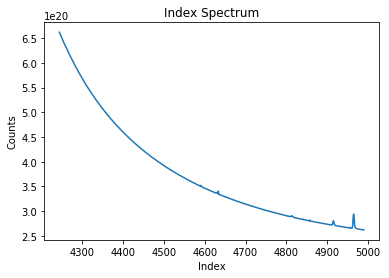

In [222]:
neb_norm = nebulae/data_fitfunc(flat_x)
mean = np.mean(neb_norm, axis=0)
ang_per_pix = 0.9747780194475906
#use shift to display angstroms of location
plt.plot(np.linspace(shift,shift + neb_norm.shape[1]*ang_per_pix, num=len(mean)),mean) 
#.97 is the angstroms per pixel that was previously calculated in lab0
plt.title("Index Spectrum")
plt.xlabel("Index")
plt.ylabel("Counts");

In [189]:
reduced_star = load_plz("../../../chris_kiran_jeffrey_lab2/*redu*")[0]

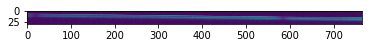

In [205]:
plt.imshow(cropped)
cropped= reduced_star[15:45,:]

In [ ]:
ang_per_pix = 0.9747780194475906
#from lab0
temp = 11361
temp_err = 66 
h = 6.626e-34
c = 3*10**8
k = 1.381e-23
def blackbody(Lambda, T):
    return 2*h*c**2/Lambda**5/(np.exp(h*c/(Lambda*k*T))-1)    

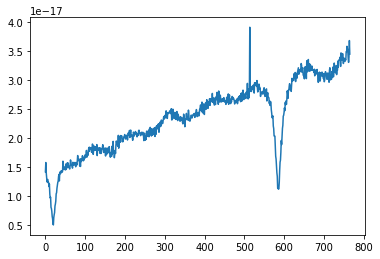

In [221]:
attempt0 = np.mean(cropped,axis=0)/blackbody(x*1e-10,temp)
plt.plot(flat_x,attempt0)
data_fitfunc = np.poly1d(np.polyfit(flat_x,attempt0,N))

In [208]:
for i in range(len(attempt0)):
    if 2<i<50 :
        attempt0[i]=(attempt0[1]+attempt0[50])/2
    if 550<i<615:
        attempt0[i]=(attempt0[549]+attempt0[620])/2
data_fitfunc = np.poly1d(np.polyfit(flat_x,attempt0,N))
for i in range(500,len(attempt0)):
    if attempt0[i] == np.min(attempt0[500:650]):
        H_abs_loc = i
shift = 4861 - H_abs_loc

In [220]:
x = np.linspace(shift,shift+len(attempt0), 765)